In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta

In [4]:
risky_assets = ['NVDA', 'TSLA', 'AMZN', 'CEMEXCPO.MX']
secure_assets = ['FUNO11.MX', 'FIBRAPL14.MX', 'NAFTRAC.MX', 'GLD']

In [7]:
tickers = risky_assets + secure_assets
RISK_FREE_RATE = 0.05

end_date = datetime.now()
start_date = end_date - timedelta(days=365*2)

In [19]:
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

[*********************100%***********************]  8 of 8 completed


In [20]:
data

Ticker,AMZN,CEMEXCPO.MX,FIBRAPL14.MX,FUNO11.MX,GLD,NAFTRAC.MX,NVDA,TSLA
Date,,,,,,,,
2023-12-04,144.839996,12.181399,70.199493,23.706066,187.860001,50.282043,45.483185,235.580002
2023-12-05,146.880005,11.993230,69.613350,23.848873,187.149994,50.291355,46.542664,238.720001
2023-12-06,144.520004,12.022942,70.510880,24.352898,187.839996,50.328606,45.480186,239.369995
2023-12-07,146.880005,12.121978,71.765587,24.403305,188.149994,50.701126,46.572647,242.639999
2023-12-08,147.419998,12.211109,72.708916,24.445305,185.639999,50.673195,47.482189,243.839996
...,...,...,...,...,...,...,...,...
2025-11-26,229.160004,19.350000,76.540001,26.750000,383.119995,63.169998,180.259995,426.579987
2025-11-27,NaN,18.920000,76.660004,26.780001,NaN,NaN,NaN,NaN
2025-11-28,233.220001,19.400000,77.809998,26.500000,387.880005,63.369999,177.000000,430.170013


In [21]:
data.dropna(axis=1, how='all', inplace=True)
data.ffill()
data.dropna(inplace=True)

In [22]:
returns = data.pct_change()
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

In [23]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculates annualized return and volatility for given weights."""
    p_return = np.sum(returns.mean() * weights) * 252
    p_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return p_return, p_std

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """Objective function to minimize (negative Sharpe = Maximize Sharpe)."""
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_return - risk_free_rate) / p_std

def minimize_volatility(weights, mean_returns, cov_matrix):
    """Objective function to minimize volatility."""
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return p_std

In [24]:
# Constraints: Weights must sum to 1, and 0 <= weight <= 1 (No shorting)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0.0, 1.0) for asset in range(len(tickers)))
init_guess = [1./len(tickers) for x in range(len(tickers))]

In [25]:
# --- Optimize for Maximum Sharpe Ratio (Best Risk-Adjusted Return) ---
opt_sharpe = sco.minimize(neg_sharpe_ratio, init_guess, 
                          args=(mean_returns, cov_matrix, RISK_FREE_RATE),
                          method='SLSQP', bounds=bounds, constraints=constraints)

# --- Optimize for Minimum Volatility (Safest) ---
opt_vol = sco.minimize(minimize_volatility, init_guess, 
                       args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)

In [26]:
# Get results
max_sharpe_ret, max_sharpe_vol = portfolio_performance(opt_sharpe.x, mean_returns, cov_matrix)
min_vol_ret, min_vol_vol = portfolio_performance(opt_vol.x, mean_returns, cov_matrix)

In [27]:
print("\nOptimization Complete.")
print(f"Max Sharpe Ratio: Return {max_sharpe_ret:.2%}, Volatility {max_sharpe_vol:.2%}")
print(f"Min Volatility:   Return {min_vol_ret:.2%}, Volatility {min_vol_vol:.2%}")


Optimization Complete.
Max Sharpe Ratio: Return 47.33%, Volatility 17.16%
Min Volatility:   Return 25.52%, Volatility 12.48%


In [28]:
# ==========================================
# 3. MONTE CARLO SIMULATION (For Visualization)
# ==========================================
# Generate thousands of random portfolios to visualize the Efficient Frontier
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    p_ret, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = p_std
    results[1,i] = p_ret
    # Sharpe Ratio
    results[2,i] = (p_ret - RISK_FREE_RATE) / p_std

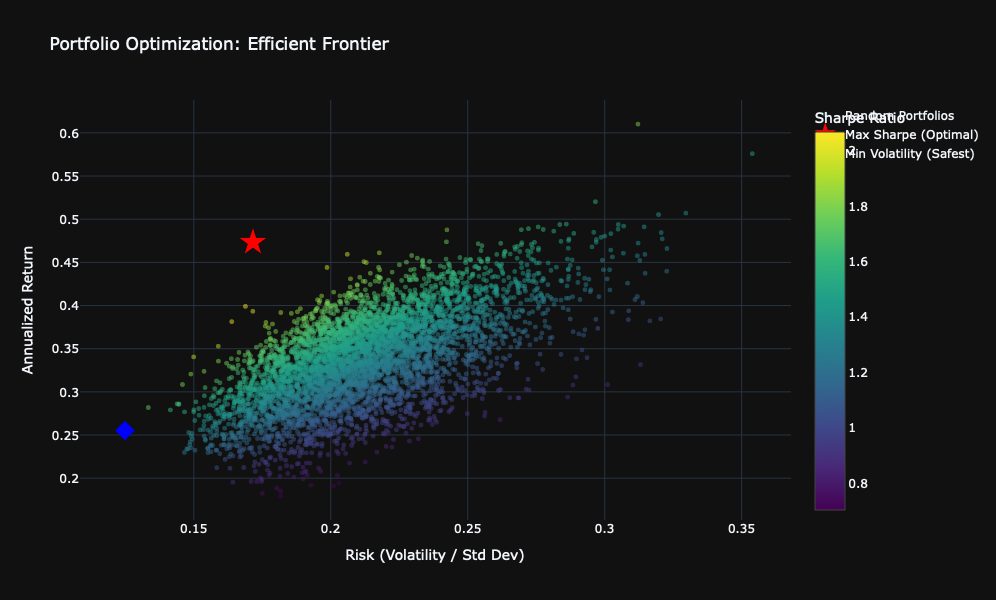

In [30]:
# ==========================================
# 4. PLOTTING WITH PLOTLY
# ==========================================

# --- PLOT 1: The Efficient Frontier ---
fig_frontier = go.Figure()

# Scatter plot of random portfolios
fig_frontier.add_trace(go.Scatter(
    x=results[0,:], 
    y=results[1,:],
    mode='markers',
    marker=dict(
        color=results[2,:], 
        colorscale='Viridis', 
        showscale=True,
        colorbar=dict(title="Sharpe Ratio"),
        size=5,
        opacity=0.5
    ),
    name='Random Portfolios'
))

# Star for Max Sharpe Portfolio
fig_frontier.add_trace(go.Scatter(
    x=[max_sharpe_vol], y=[max_sharpe_ret],
    mode='markers',
    marker=dict(color='red', size=20, symbol='star'),
    name='Max Sharpe (Optimal)'
))

# Diamond for Min Volatility Portfolio
fig_frontier.add_trace(go.Scatter(
    x=[min_vol_vol], y=[min_vol_ret],
    mode='markers',
    marker=dict(color='blue', size=15, symbol='diamond'),
    name='Min Volatility (Safest)'
))

fig_frontier.update_layout(
    title='Portfolio Optimization: Efficient Frontier',
    xaxis=dict(title='Risk (Volatility / Std Dev)'),
    yaxis=dict(title='Annualized Return'),
    width=900, height=600,
    template='plotly_dark'
)


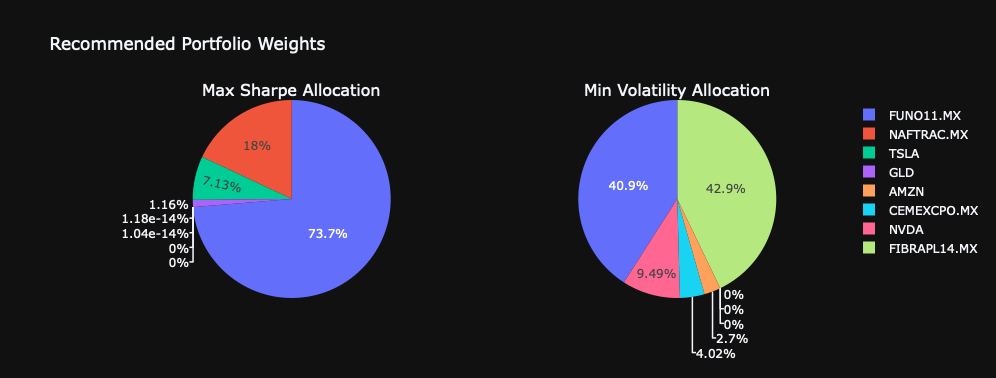

In [31]:
# --- PLOT 2: Optimal Asset Allocation (Pie Charts) ---
# Create a DataFrame for weights
weights_df = pd.DataFrame({
    'Asset': tickers,
    'Max Sharpe Weights': opt_sharpe.x,
    'Min Volatility Weights': opt_vol.x
})

# Filter out very small weights for cleaner charts
weights_df_clean = weights_df[weights_df[['Max Sharpe Weights', 'Min Volatility Weights']].max(axis=1) > 0.01]

from plotly.subplots import make_subplots

fig_pie = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                        subplot_titles=['Max Sharpe Allocation', 'Min Volatility Allocation'])

fig_pie.add_trace(go.Pie(labels=weights_df_clean['Asset'], values=weights_df_clean['Max Sharpe Weights'], name="Max Sharpe"),
              1, 1)
fig_pie.add_trace(go.Pie(labels=weights_df_clean['Asset'], values=weights_df_clean['Min Volatility Weights'], name="Min Vol"),
              1, 2)

fig_pie.update_layout(title_text="Recommended Portfolio Weights", template='plotly_dark')


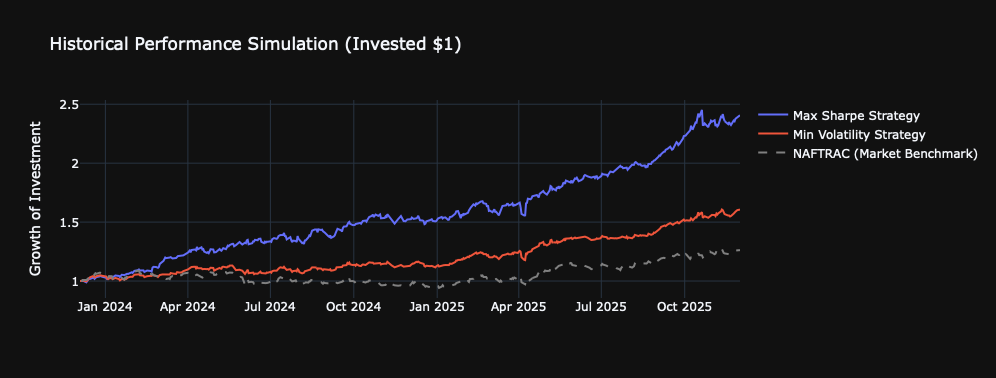

In [32]:
# --- PLOT 3: Cumulative Returns Comparison ---
# Calculate the daily value of $1000 invested in each strategy
weighted_returns_sharpe = (returns * opt_sharpe.x).sum(axis=1)
weighted_returns_vol = (returns * opt_vol.x).sum(axis=1)

cumulative_sharpe = (1 + weighted_returns_sharpe).cumprod()
cumulative_vol = (1 + weighted_returns_vol).cumprod()

fig_cum = go.Figure()
fig_cum.add_trace(go.Scatter(x=cumulative_sharpe.index, y=cumulative_sharpe, mode='lines', name='Max Sharpe Strategy'))
fig_cum.add_trace(go.Scatter(x=cumulative_vol.index, y=cumulative_vol, mode='lines', name='Min Volatility Strategy'))
fig_cum.add_trace(go.Scatter(x=data.index, y=(1+returns['NAFTRAC.MX']).cumprod(), mode='lines', name='NAFTRAC (Market Benchmark)', line=dict(dash='dash', color='gray')))

fig_cum.update_layout(
    title='Historical Performance Simulation (Invested $1)',
    yaxis_title='Growth of Investment',
    template='plotly_dark'
)

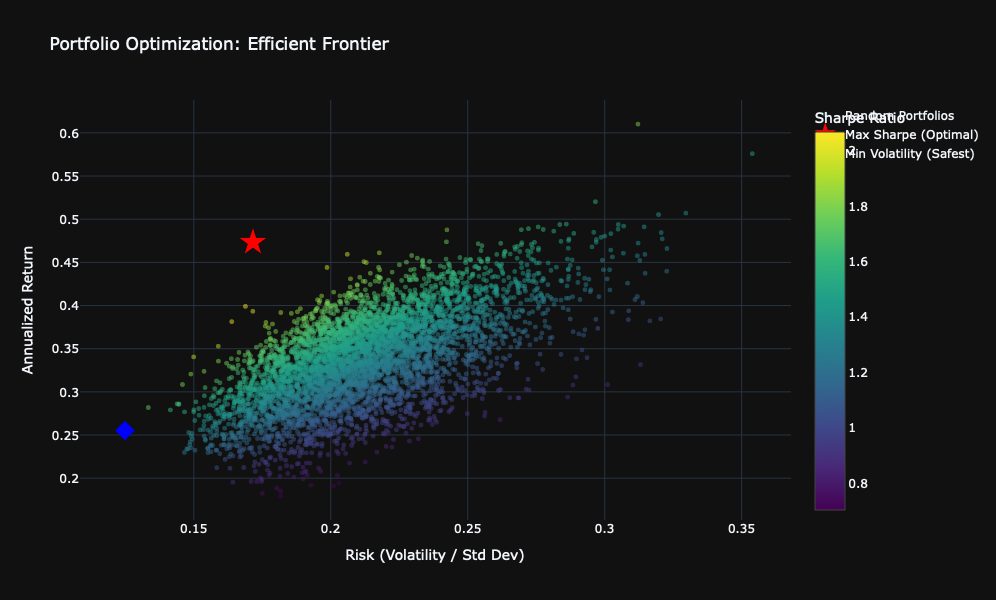

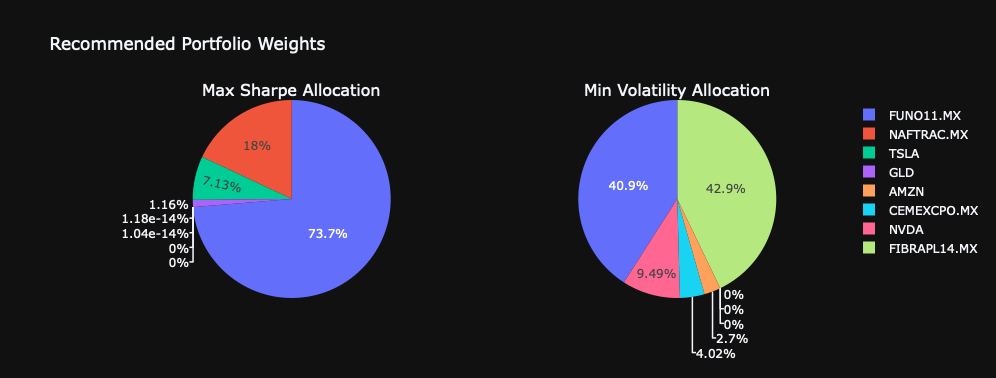

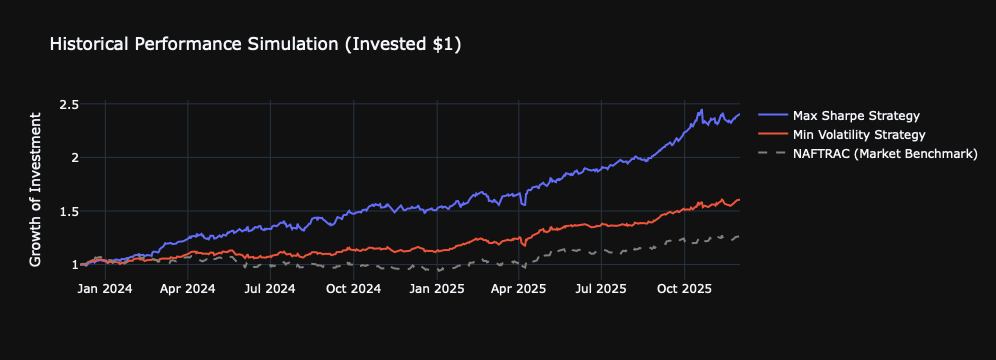

In [33]:
# Display plots
fig_frontier.show()
fig_pie.show()
fig_cum.show()